# Import libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import exp, sqrt, pi


In [40]:
import kagglehub
import os
import zipfile

## Prerequisite conditions to apply Naive-Bayes classifier:

Ideally, the dependent variable (target Y) should be evenly distributed across classes.

Each feature must be independent of the others, given the class label.

Assumes continuous features follow a normal (Gaussian) distribution.

No Multicollinearity between variables.


# Import dataset

In [41]:
# Import dataset from kaggle
path = kagglehub.dataset_download("zeeshier/weather-forecast-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/zeeshier/weather-forecast-dataset/versions/1


In [42]:
zip_path = "{path}.zip"
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(path)

# List extracted files
print("Extracted files:", os.listdir(path))

Extracted files: ['weather_forecast_data.csv']


In [43]:
# Read file in csv
csv_file_path = os.path.join(path, "weather_forecast_data.csv")
df = pd.read_csv(csv_file_path)

In [44]:
df.head()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


#EDA

<Axes: >

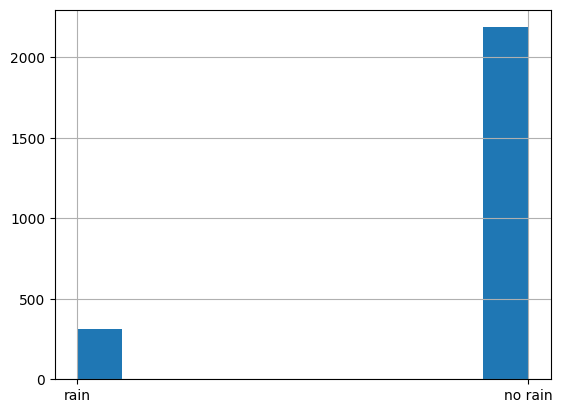

In [45]:
df['Rain'].hist()

Even though the class is not evenly distributed, we continue since the scope of the project is to try implementing Naive- Bayes algorithm using pandas.

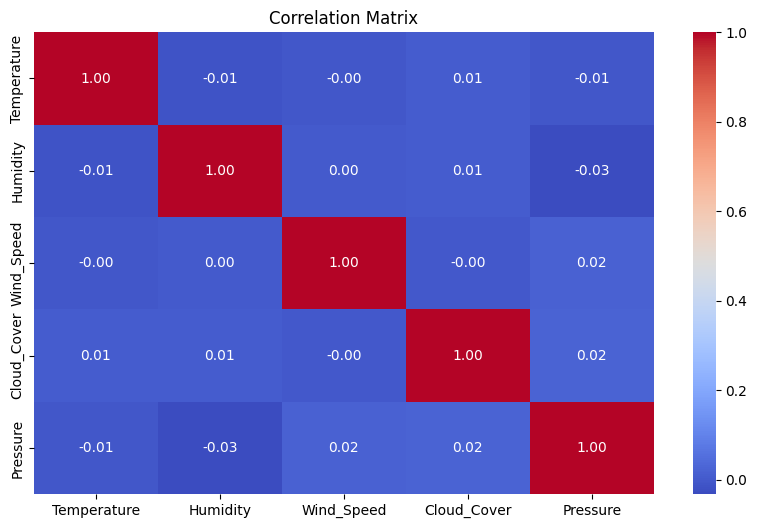

In [46]:
# Check for correlation between variables.
corr_matrix = df.iloc[:,:-1].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

No correlation between x varibales. Therefore can use it all for prediction.

We keep all variables since correlation is less among the variables. Other methods can also be used to check if variables are independency. (chi- square test, anova etc..)

Label encoding converts categorical values into numerical values, making them suitable for input in Naive Bayes.

In [47]:
# Label encoding
df['Rain'] = df['Rain'].replace({'rain': 1, 'no rain': 0})

<ipython-input-47-c62346b2dd2d>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Rain'] = df['Rain'].replace({'rain': 1, 'no rain': 0})


In [48]:
df.head()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,1
1,27.879734,46.489704,5.952484,4.990053,992.614190,0
2,25.069084,83.072843,1.371992,14.855784,1007.231620,0
3,23.622080,74.367758,7.050551,67.255282,982.632013,1
4,20.591370,96.858822,4.643921,47.676444,980.825142,0


# Guassian probability function

## Naïve Bayes Classifier

The Naïve Bayes classifier is based on **Bayes' Theorem**:

$P(Y \mid X) = \frac{P(X \mid Y) P(Y)}{P(X)}$

<br>


Since $P(X)$ is constant for all classes, we only need to calculate the numerator:

$P(Y \mid X) \propto P(X \mid Y) P(Y)$

<br>

For multiple independent features $X_1, X_2, ..., X_n$, the likelihood is:

$P(Y \mid X_1, X_2, ..., X_n) \propto P(Y) \prod_{i=1}^{n} P(X_i \mid Y)$

<br>


If assuming a **Gaussian distribution**, the likelihood of a feature is given by:

$P(X_i \mid Y) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left(-\frac{(X_i - \mu)^2}{2\sigma^2} \right)$

where:

- $\mu$: Mean of the feature for class $Y$
- $\sigma$: Standard deviation of the feature for class $Y$


<br>

To classify a new sample, we compute **posterior probabilities** for each class and pick the class with the highest probability:

$Y_{\text{pred}} = \arg\max_Y P(Y) \prod_{i=1}^{n} P(X_i \mid Y)$



**Goal:** Find the class $Y$ that maximizes the posterior probability.

**Steps:**

1.  **Calculate the Prior Probability:**  $P(Y)$
    *   Estimate the prior probability for each class Y from the training data.  This is the proportion of samples belonging to class Y.

2.  **Calculate the Likelihood:** $\prod_{i=1}^{n} P(X_i \mid Y)$
    *   For each feature $X_i$ and class $Y$, calculate the conditional probability $P(X_i \mid Y)$ using the Gaussian distribution formula above.
    *   Multiply these probabilities together across all features to get the likelihood for class $Y$.

3.  **Calculate Naïve Bayes and Predict:**
    *   For each class $Y$, calculate: `Naive_Bayes_Score(Y) = P(Y) *  Likelihood(Y)`
    *   Predict the class with the highest Naïve Bayes score:
        $Y_{\text{pred}} = \arg\max_Y P(Y) \prod_{i=1}^{n} P(X_i \mid Y)$

In [49]:
# Calculate prior P(Y=y)
def calculate_prior(df,Y):
  arr = []
  classes = df[Y].unique()
  for clas in classes:
    clas_div_total = len(df[df[Y]==clas])/ len(df)
    arr.append(clas_div_total)
  return arr



In [50]:
calculate_prior(df,'Rain')

[0.1256, 0.8744]

In [51]:
# Calculate the Likelihood value
def likelihood(df, feature_name, feature_value, Y,label):  # input data, X,x0, Y, y

  df = df[df[Y]==label]
  x_mean = df[feature_name].mean()



  stdev =  df[feature_name].std()

  if stdev == 0:
        stdev = 1e-6  # Small constant to avoid ZeroDivisionError

  exponent = exp(-((feature_value- x_mean)**2 / (2 * stdev**2 )))

  p_X_given_Y = (1 / (sqrt(2 * pi) * stdev)) * exponent
  return p_X_given_Y


In [52]:
likelihood(df,'Temperature',23.319913429721986, 'Rain',0)

0.05408105339241624

# Implementing the Naive-Bayes classifier

In [53]:
# calculate posterior = prior * likelihood for each class and find argmax.
def naive_bayes(df,X,Y):

  unique_labels = sorted(df[Y].unique())
  features = list(df.columns)[:-1]

  prior = calculate_prior(df,Y)

  final = []

  for x in X: # loop over each row of test data

    rhs = []
    for j in range(len(unique_labels)): # loop over each Y value (yes, no)
      likely = 1

      # Find Right handside value of the formula here

      for i in range(len(features)): # loop over each column of the dataset df to get likelihood
        likely = likely* likelihood(df,features[i],x[i],Y,unique_labels[j])

      rhs.append(likely*prior[j])

    #print(rhs)
    final.append(np.argmax(rhs))

  return final

In [54]:
# Testing the naive_Bayes function
Test = df.iloc[:,:-1]
naive_bayes(df,Test.iloc[0:2].values.tolist(),'Rain')

[1, 0]

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score


train, test = train_test_split(df, test_size=.2, random_state=49)   # Train, test dataset split

X_test = test.iloc[:,: -1].values # Remove the Y column
Y_test = test.iloc[:,-1].values   # Keep the Y column

Y_pred = naive_bayes(train, X= X_test,Y= "Rain")   # Apply Naive - Bayes algorithm

print("Confusion Matrix:")
print(confusion_matrix( Y_test, Y_pred))
print('\n')
print("f1 Score:")
print(f1_score(Y_test, Y_pred))

Confusion Matrix:
[[430   0]
 [ 21  49]]


f1 Score:
0.8235294117647058


# References

**Comments:** The Naive Bayes algorithm has been successfully implemented using pandas. However, there are potential improvements that can be made, such as balancing the unbalanced Y variable, applying smoothing techniques, and converting continuous variables into categorical ones before implementing Naive Bayes.

I used several websites and videos for understanding the concepts and applying them in pandas.

1. https://web.stanford.edu/~jurafsky/slp3/4.pdf
2. https://www.youtube.com/watch?v=H3EjCKtlVog
3. https://www.youtube.com/watch?v=3I8oX3OUL6I&t=638s